In [1]:
import os

os.chdir("C:\\Users\\CeNTREX\\Documents\\GitHub\\1-3-IR-high_voltage\\Short IR electrodes test")

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit
from RadEyeG20 import * 
from queue import Queue, Empty
import h5py
import pyvisa
import time
import multiprocessing as mp
from scipy.signal import savgol_filter
import scipy.signal as signal
from scipy import interpolate
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.ticker import MaxNLocator
from scipy.optimize import least_squares
import threading
import nidaqmx
import pandas as pd

# If the imports don't work, press F1, find "Developer: Reload Window"

factor = 2
SMALL_SIZE = factor*8
MEDIUM_SIZE = factor*10
BIGGER_SIZE = factor*12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title4

#rm = pyvisa.ResourceManager()
#rm.list_resources()


In [2]:
import os

os.chdir("C:\\Users\\CeNTREX\\Documents\\GitHub\\1-3-IR-high_voltage\\Short IR electrodes test\\4-1-2025_test")

#### Load NI USB6002 for voltage ramp and data reading

In [3]:
device_name = "dev1"
DAQ_read_channels = ["ai0","ai1","ai2", "ai3"]
DAQ_write_channel = "ao0"
DAQ_timeout = 5000

#### Load Radeye for X ray reading

In [4]:
# Example usage
time_offset = 1
com_port =  'ASRL4::INSTR'  # Replace with detected COM port
radeye = RadEyeG20(time_offset , com_port)

In [5]:
%%timeit
radeye.instr.clear()

274 ms ± 6.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Data collection functions

In [6]:
# RAMP TO VOLTAGE 


def ramp_to(start_v, end_v, total_ramp_time=60, v_step=0.001):
    """
    Ramps the voltage on the DAQ output from start_v to end_v over total_ramp_time, using steps of v_step.
    
    Parameters:
        start_v (float): Starting voltage, must be between 0 and 10.1.
        end_v (float): Ending voltage, must be between 0 and 10.1.
        total_ramp_time (float): Total time for the voltage ramp (default is 60 seconds).
        v_step (float): Voltage step (default is 0.001 volts).
    """
    # Check if input voltages are within the valid range
    if not (0 <= start_v <= 10.1) or not (0 <= end_v <= 10.1):
        print("Error: Voltage must be between 0 and 10.1 volts.")
        return
    
    # Calculate the total number of steps and the time interval (dt) between steps
    voltage_range = abs(end_v - start_v)
    num_steps = int(voltage_range / v_step)  # Number of voltage steps
    dt = total_ramp_time / num_steps  # Time between each voltage step
    print(dt)
    
    # Set the initial voltage to start_v
    current_voltage = start_v

    try:
        with nidaqmx.Task() as task:
            # Configure the AO0 channel on device "dev1"
            task.ao_channels.add_ao_voltage_chan("dev1/ao0", min_val=0.0, max_val=10.1)
            
            # Set the initial voltage to start_v
            task.write(current_voltage)
            print(f"Starting ramp from {start_v}V to {end_v}V with step {v_step}V.")
            
            # Determine the direction of the ramp (up or down)
            step_direction = 1 if end_v > start_v else -1
            
            for _ in range(num_steps):
                # Update the current voltage in the direction of the ramp
                current_voltage += step_direction * v_step
                
                # Output the new voltage to the DAQ
                task.write(current_voltage)
                print(f"current voltage: {current_voltage}V.")
                
                # Wait for the calculated time step
                time.sleep(dt)
                
                # Placeholder for additional error checking or exception handling
                # You can add custom error handling code here
                pass

    except Exception as e:
        # If any exception occurs, handle it here
        print(f"An exception occurred: {str(e)}. Exiting ramp.")
        return

    print(f"Successfully ramped from {start_v}V to {current_voltage}V.")


def ramp_multi(min_v, max_v, tot_measure_time, total_rampup_time=60,total_rampdown_time=60, v_step=0.01):
    
    for i in range(tot_measure_time):

        ramp_and_record(min_v,max_v, i, total_rampup_time, v_step)

        record(300,i,"rec_at_10_")

        ramp_and_record(max_v,min_v, i, total_rampdown_time, v_step)

        record(60,i,"rec_at_0_")

    


In [7]:
def ramp_and_record_live_stream(start_v, end_v, measure_time, total_ramp_time=60, v_step=0.001,
                                filename="ramp_and_record_live_stream", radeye=None,
                                plot_interval=10, buffer_size=10):

    if not (0 <= start_v <= 10.1) or not (0 <= end_v <= 10.1):
        return

    voltage_range = abs(end_v - start_v)
    num_steps = int(np.ceil(voltage_range / v_step))
    dt = total_ramp_time / num_steps
    step_direction = 1 if end_v > start_v else -1
    current_voltage = start_v
    voltage_cut = threading.Event()
    high_dose_count = 0

    xray_connected = radeye is not None and radeye.instr is not False

    full_file_name = f"{filename}_{start_v:.3f}V_to_{end_v:.3f}V_step_{v_step}V_in_{total_ramp_time}s_{measure_time}.hdf"
    if os.path.exists(full_file_name):
        os.remove(full_file_name)

    xray_times, xray_doses = [], []
    daq_times, voltage1_log, voltage2_log, current1_log, current2_log = [], [], [], [], []
    daq_buffer = []
    xray_queue = Queue()

    if xray_connected:
        plt.ioff()
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
        line1, = ax1.plot([], [], label="X-ray Dose (µSv/h)", marker='o')
        line2a, = ax2.plot([], [], label="Voltage 1 (V)", marker='.')
        line2b, = ax2.plot([], [], label="Voltage 2 (V)", marker='.')
        line3a, = ax3.plot([], [], label="Current 1 (A)", marker='.')
        line3b, = ax3.plot([], [], label="Current 2 (A)", marker='.')
        for ax in [ax1, ax2, ax3]:
            ax.grid(True)
        ax2.legend()
        ax3.legend()
        ax1.set_ylabel("Dose Rate (µSv/h)")
        ax2.set_ylabel("Voltage (kV)")
        ax3.set_ylabel("Current (uA)")
        ax3.set_xlabel("Elapsed Time (s)")
        ax1.set_title("Live X-ray Dose, Voltage, and Current")

    h5f = h5py.File(full_file_name, "w")

    daq_columns = ["Elapsed_Time"] + DAQ_read_channels
    dset_daq = h5f.create_dataset(
        "daq_data", shape=(0, len(daq_columns)),
        maxshape=(None, len(daq_columns)), dtype='float64', chunks=True
    )
    dset_daq.attrs["columns"] = daq_columns
    dset_daq.attrs["start_voltage"] = start_v
    dset_daq.attrs["end_voltage"] = end_v
    dset_daq.attrs["voltage_step"] = v_step

    if xray_connected:
        xray_columns = ["Elapsed_Time", "Xray_DoseRate_uSv_h"]
        dset_xray = h5f.create_dataset(
            "xray_data", shape=(0, len(xray_columns)),
            maxshape=(None, len(xray_columns)), dtype='float64', chunks=True
        )
        dset_xray.attrs["sample_interval"] = 1.0
        dset_xray.attrs["columns"] = xray_columns

    def xray_worker():
        consec_high_dose = 0
        start_time = time.time()

        while True:
            elapsed = time.time() - start_time
            try:
                _, xray_dose_nSv = radeye.ReadValue()
                xray_dose_uSv = xray_dose_nSv / 1000.0
                xray_queue.put((elapsed, xray_dose_uSv))

                if xray_dose_uSv > 0.5:
                    consec_high_dose += 1
                else:
                    consec_high_dose = 0

                if consec_high_dose >= 2 and not voltage_cut.is_set():
                    voltage_cut.set()
                    print(f"⚠️ 2 consecutive X-ray readings > 0.5 µSv — voltage ramping to 0 V.")
                    
                if read_count % 5 == 0:
                    radeye.instr.flush(pyvisa.constants.BufferOperation.discard_read)
                read_count += 1

            except Exception:
                time.sleep(0.1)
                continue

            #time.sleep(1.)

    if xray_connected:
        xray_thread = threading.Thread(target=xray_worker, daemon=True)
        xray_thread.start()

    with nidaqmx.Task() as read_task, nidaqmx.Task() as write_task:
        for ch in DAQ_read_channels:
            read_task.ai_channels.add_ai_voltage_chan(f"{device_name}/{ch}")
        write_task.ao_channels.add_ao_voltage_chan(
            f"{device_name}/{DAQ_write_channel}", min_val=0.0, max_val=10.1)

        read_task.start()
        write_task.write(current_voltage)
        start_time = time.time()

        for step in range(num_steps):
            elapsed = time.time() - start_time

            if not voltage_cut.is_set():
                current_voltage += step_direction * v_step
                write_task.write(current_voltage)
            else:
                write_task.write(0.0)

            raw_daq = read_task.read(number_of_samples_per_channel=10)
            daq_values = [v[0] for v in raw_daq]

            row_data = [elapsed] + daq_values
            daq_buffer.append(row_data)

            daq_times.append(elapsed)
            voltage1_log.append(daq_values[0] / 10 * 30)
            current1_log.append(daq_values[1] / 10 * 400)
            voltage2_log.append(daq_values[2] / 10 * 30)
            current2_log.append(daq_values[3] / 10 * 400)

            # Batch write to HDF5
            if len(daq_buffer) >= buffer_size:
                dset_daq.resize((dset_daq.shape[0] + len(daq_buffer), dset_daq.shape[1]))
                dset_daq[-len(daq_buffer):] = np.array(daq_buffer)
                daq_buffer.clear()

            # Handle X-ray readings
            try:
                while True:
                    xray_elapsed, xray_dose = xray_queue.get_nowait()
                    xray_times.append(xray_elapsed)
                    xray_doses.append(xray_dose)
                    dset_xray.resize((dset_xray.shape[0] + 1, dset_xray.shape[1]))
                    dset_xray[-1:] = np.array([[xray_elapsed, xray_dose]])
            except Empty:
                pass

            # Update plot only every `plot_interval` steps
            if xray_connected and (step % plot_interval == 0 or step == num_steps - 1):
                line1.set_data(xray_times, xray_doses)
                line2a.set_data(daq_times, voltage1_log)
                line2b.set_data(daq_times, voltage2_log)
                line3a.set_data(daq_times, current1_log)
                line3b.set_data(daq_times, current2_log)
                for ax in [ax1, ax2, ax3]:
                    ax.relim()
                    ax.autoscale_view()
                clear_output(wait=True)
                display(fig)
                plt.pause(0.001)

            time.sleep(dt)

    # Final flush
    if daq_buffer:
        dset_daq.resize((dset_daq.shape[0] + len(daq_buffer), dset_daq.shape[1]))
        dset_daq[-len(daq_buffer):] = np.array(daq_buffer)

    h5f.close()
    print(f"Ramp completed. Data saved to: {full_file_name}")


In [ ]:
def record_live_stream(duration=60, filename="record_live_stream", radeye=None,
                       plot_interval=10, buffer_size=10):

    xray_connected = radeye is not None and radeye.instr is not False
    full_file_name = f"{filename}_{duration}s.hdf"

    if os.path.exists(full_file_name):
        os.remove(full_file_name)

    xray_queue = Queue()
    daq_times, voltage1_log, voltage2_log, current1_log, current2_log = [], [], [], [], []
    xray_times, xray_doses = [], []
    daq_buffer = []

    if xray_connected:
        plt.ioff()
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
        line1, = ax1.plot([], [], label="X-ray Dose (µSv/h)", marker='o')
        line2a, = ax2.plot([], [], label="Voltage 1 (V)", marker='x')
        line2b, = ax2.plot([], [], label="Voltage 2 (V)", marker='x')
        line3a, = ax3.plot([], [], label="Current 1 (A)", marker='^')
        line3b, = ax3.plot([], [], label="Current 2 (A)", marker='^')
        for ax in [ax1, ax2, ax3]:
            ax.grid(True)
        ax2.legend()
        ax3.legend()
        ax1.set_ylabel("Dose Rate (µSv/h)")
        ax2.set_ylabel("Voltage (V)")
        ax3.set_ylabel("Current (A)")
        ax3.set_xlabel("Elapsed Time (s)")
        ax1.set_title("Live X-ray Dose, Voltage, and Current")

    h5f = h5py.File(full_file_name, "w")

    daq_columns = ["Elapsed_Time"] + DAQ_read_channels
    dset_daq = h5f.create_dataset(
        "daq_data", shape=(0, len(daq_columns)), maxshape=(None, len(daq_columns)),
        dtype='float64', chunks=True
    )
    dset_daq.attrs["columns"] = daq_columns

    if xray_connected:
        xray_columns = ["Elapsed_Time", "Xray_DoseRate_uSv_h"]
        dset_xray = h5f.create_dataset(
            "xray_data", shape=(0, len(xray_columns)), maxshape=(None, len(xray_columns)),
            dtype='float64', chunks=True
        )
        dset_xray.attrs["sample_interval"] = 1.0
        dset_xray.attrs["columns"] = xray_columns

        def xray_worker():
            read_count = 0
            start_time = time.time()
            while time.time() - start_time < duration + 5:
                try:
                    _, dose_nSv = radeye.ReadValue()
                    dose_uSv = dose_nSv / 1000.0
                    elapsed = time.time() - start_time
                    xray_queue.put((elapsed, dose_uSv))
                    if read_count % 5 == 0:
                        radeye.instr.clear()
                    read_count += 1
                except Exception:
                    time.sleep(0.1)
                    continue
                time.sleep(1.0)

        xray_thread = threading.Thread(target=xray_worker, daemon=True)
        xray_thread.start()

    with nidaqmx.Task() as read_task:
        for ch in DAQ_read_channels:
            read_task.ai_channels.add_ai_voltage_chan(f"{device_name}/{ch}")
        read_task.start()

        start_time = time.time()
        step = 0
        while (time.time() - start_time) < duration:
            elapsed = time.time() - start_time
            raw_daq = read_task.read(number_of_samples_per_channel=10)
            daq_values = [v[0] for v in raw_daq]
            row_data = [elapsed] + daq_values
            daq_buffer.append(row_data)

            daq_times.append(elapsed)
            voltage1_log.append(daq_values[0])
            current1_log.append(daq_values[1])
            voltage2_log.append(daq_values[2])
            current2_log.append(daq_values[3])

            if len(daq_buffer) >= buffer_size:
                dset_daq.resize((dset_daq.shape[0] + len(daq_buffer), dset_daq.shape[1]))
                dset_daq[-len(daq_buffer):] = np.array(daq_buffer)
                daq_buffer.clear()

            try:
                while True:
                    xray_elapsed, xray_dose = xray_queue.get_nowait()
                    xray_times.append(xray_elapsed)
                    xray_doses.append(xray_dose)
                    dset_xray.resize((dset_xray.shape[0] + 1, dset_xray.shape[1]))
                    dset_xray[-1:] = np.array([[xray_elapsed, xray_dose]])
            except Empty:
                pass

            if xray_connected and (step % plot_interval == 0 or step == int(duration)):
                line1.set_data(xray_times, xray_doses)
                line2a.set_data(daq_times, voltage1_log)
                line2b.set_data(daq_times, voltage2_log)
                line3a.set_data(daq_times, current1_log)
                line3b.set_data(daq_times, current2_log)
                for ax in [ax1, ax2, ax3]:
                    ax.relim()
                    ax.autoscale_view()
                clear_output(wait=True)
                display(fig)
                plt.pause(0.001)

            time.sleep(0.01)
            step += 1

    if daq_buffer:
        dset_daq.resize((dset_daq.shape[0] + len(daq_buffer), dset_daq.shape[1]))
        dset_daq[-len(daq_buffer):] = np.array(daq_buffer)

    h5f.close()
    print(f"Recording finished. Data saved to: {full_file_name}")


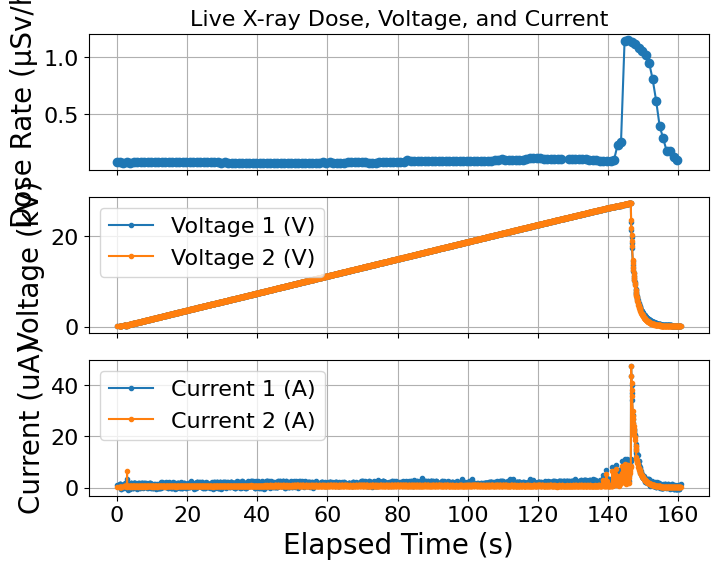

Ramp completed. Data saved to: ramp_switch_polarity_0.000V_to_10.000V_step_0.005V_in_120s_3.hdf


In [8]:
os.chdir("C:\\Users\\CeNTREX\\Documents\\GitHub\\1-3-IR-high_voltage\\Short IR electrodes test\\4-6-2025_test")

ramp_and_record_live_stream(start_v=0.,end_v=10.,measure_time = 3,total_ramp_time=120, filename="ramp_switch_polarity",v_step=0.005, radeye=radeye)